# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [ ]:
lucem_illud.setupStanfordNLP()

We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [2]:
import lucem_illud.stanford as stanford

/usr/local/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [133]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [ ]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [ ]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [ ]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

In [ ]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [ ]:
redditTopScores['POS_sents']

And count the number of `NN` (nouns)

In [ ]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

What about the number of top verbs (`VB`)?

In [ ]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

What about the adjectives that modify the word, "computer"?

In [ ]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [ ]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

In [ ]:
treeBank.sents()[0]

In [ ]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [ ]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [12]:
news_df_total = pandas.read_pickle('../data/news_better.pkl')
news_df = news_df_total.sample(100)

In [177]:
news_df['sentences'] = news_df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

In [13]:
news_df['POS_sents'] = news_df['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [150]:
from collections import Counter
def pos_counter(target_pos, pos_sentences):
    targetCounts = Counter()
    for entry in pos_sentences:
        for sentence in entry:
            for ent, kind in sentence:
                if not kind.startswith(target_pos):
                    continue
                targetCounts.update([ent])
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedTargets

def pos_collocation_counter(target_pos, pos_sentences, target_word, pos_after=False):
    counts = Counter()
    for entry in pos_sentences:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if pos_after and ent2.lower()==target_word and kind1.startswith(target_pos): #(kind1,ent2.lower())==(target_pos,target_word):
                    counts.update([ent1])
                elif not pos_after and ent1.lower()==target_word and kind2.startswith(target_pos): #(kind2, ent1.lower())==(target_pos,target_word):
                    counts.update([ent2])
                else:
                    continue
    return sorted(counts.items(), key = lambda x: x[1], reverse = True)

I´m interested in looking at combinations of verbs and modals. Let´s look at the modals in our sample

In [151]:
pos_counter('MD', news_df['POS_sents'])[:20]

[('will', 247),
 ('would', 130),
 ('can', 106),
 ('should', 72),
 ('could', 57),
 ('may', 31),
 ('must', 30),
 ('might', 15),
 ('wo', 6),
 ("'ll", 4),
 ('ca', 2),
 ('shall', 2),
 ('Should', 1),
 ('Would', 1),
 ('ought', 1),
 ('Could', 1)]

In [152]:
pos_counter('VB', news_df['POS_sents'])[:20]

[('is', 678),
 ('said', 376),
 ('are', 338),
 ('be', 296),
 ('has', 266),
 ('have', 220),
 ('was', 164),
 ('been', 86),
 ('do', 72),
 ('had', 69),
 ("'s", 61),
 ('were', 55),
 ('made', 53),
 ('including', 49),
 ('s', 47),
 ('being', 46),
 ('developing', 45),
 ('make', 43),
 ('need', 43),
 ('take', 42)]

We see that the most common verbs are 'is', which could be indicative of passive voice in news, and 'said', which is expected given news reporting of quotes. Our verbs lean more towards the present (are, is) and, interestingly, the future (will). <br>
Let's look at the different verbs that are being conjugated in both past and future tenses.

In [162]:
pos_collocation_counter('VB', news_df['POS_sents'], 'will')[:60]

[('be', 64),
 ('have', 7),
 ('continue', 5),
 ('need', 5),
 ('hold', 4),
 ('take', 4),
 ('bring', 4),
 ('stick', 3),
 ('reach', 3),
 ('depend', 3),
 ('find', 2),
 ('host', 2),
 ('remain', 2),
 ('withdraw', 2),
 ('start', 2),
 ('see', 2),
 ('increase', 2),
 ('affect', 2),
 ('change', 2),
 ('go', 2),
 ('benefit', 2),
 ('come', 2),
 ('leave', 2),
 ('put', 2),
 ('try', 2),
 ('exceed', 2),
 ('promote', 2),
 ('live', 1),
 ('consume', 1),
 ('advise', 1),
 ('include', 1),
 ('become', 1),
 ('react', 1),
 ('stay', 1),
 ('require', 1),
 ('allocate', 1),
 ('announce', 1),
 ('tell', 1),
 ('invite', 1),
 ('introduce', 1),
 ('send', 1),
 ('speak', 1),
 ('convene', 1),
 ('reduce', 1),
 ('reveal', 1),
 ('ensure', 1),
 ('drive', 1),
 ('spare', 1),
 ('sustain', 1),
 ('drop', 1),
 ('act', 1),
 ('provide', 1),
 ('study', 1),
 ('get', 1),
 ('occur', 1),
 ('replace', 1),
 ('dominate', 1),
 ('argue', 1),
 ('necessitate', 1),
 ('strengthen', 1)]

There's a tonal mix here, with verbs like 'sustain' and 'benefit' on the positive side, and 'exceed' and 'withdraw' on the negative side, with multiple verbs being more neutral ('require', 'stick'). 

In [159]:
pos_collocation_counter('VB', news_df['POS_sents'], 'have')[:30]

[('been', 25),
 ('seen', 3),
 ('reached', 3),
 ('shown', 3),
 ('had', 3),
 ('committed', 3),
 ('lost', 2),
 ('gone', 2),
 ('exceeded', 2),
 ('left', 2),
 ('fallen', 2),
 ('made', 2),
 ('found', 2),
 ('depleted', 2),
 ('failed', 2),
 ('proposed', 2),
 ('contributed', 2),
 ('done', 2),
 ('witnessed', 2),
 ('gained', 1),
 ('mobilised', 1),
 ('formed', 1),
 ('set', 1),
 ('outlived', 1),
 ('urged', 1),
 ('used', 1),
 ('lagged', 1),
 ('become', 1),
 ('caused', 1),
 ('stepped', 1)]

Very different set of verbs now, with a stronger attitude. Now verbs such as 'depleted', 'failed', 'reached' and 'lost' tell us the narrative that negative consequences have happened.
In conjunction with the verbs used in the future tense, the narrative news seem to be telling is one of a tragic past and an uncertain future.

In [164]:
pos_collocation_counter('JJ', news_df['POS_sents'], 'is')[:30]

[('important', 5),
 ('necessary', 4),
 ('more', 4),
 ('likely', 3),
 ('critical', 3),
 ('obvious', 2),
 ('worth', 2),
 ('great', 2),
 ('willing', 2),
 ('ready', 2),
 ('real', 2),
 ('valid', 2),
 ('unlikely', 2),
 ('interested', 2),
 ('strong', 2),
 ('hard', 1),
 ('accessible', 1),
 ('superior', 1),
 ('vital', 1),
 ('restorative', 1),
 ('inconclusive', 1),
 ('relevant', 1),
 ('basic', 1),
 ('uncertain', 1),
 ('possible', 1),
 ('intermittent', 1),
 ('unfamiliar', 1),
 ('such', 1),
 ('laughable', 1),
 ('widespread', 1)]

The adjectives we have tell a story of the importance ('important', 'necessary', 'critical', 'vital', 'widespread') of the topic. The adjectives are in general very strong, which is interesting on itself, they are overwhelmingly not about subtlety, which might reflect the psychological state that reporters want to convey.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [ ]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

We can also run NER over our entire corpus:

In [ ]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [ ]:
redditTopScores['classified_sents']

Find the most common entities (which are, of course, boring):

In [ ]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

Or those occurring only twice:

In [ ]:
[x[0] for x in sortedEntities if x[1] == 2]

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [ ]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

What about the Organizations?

In [ ]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

In [20]:
news_df['classified_sents'] = news_df['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [22]:
def type_counter(sentences):
    dict_counts = {}
    for entry in sentences:
        for sentence in entry:
            for ent, kind in sentence:
                if kind in dict_counts:
                    dict_counts[kind] += 1
                else:
                    dict_counts[kind] = 1
    return dict_counts
type_counter(news_df['classified_sents'])

{'LOCATION': 1363, 'O': 60580, 'ORGANIZATION': 1710, 'PERSON': 1258}

We have numbers on a similar scale for locations, organizations and people, with other objects on a larger scale. The first one probably reflects the setting up the context of the news articles, which usually include locations and organizations.

In [24]:
pos_counter(pos_sentences=news_df['classified_sents'], target_pos='PERSON')[:30]

[('Trump', 94),
 ('Xi', 40),
 ('Donald', 33),
 ('Brown', 19),
 ('Howe', 18),
 ('Harvey', 16),
 ('Jinping', 14),
 ('Obama', 11),
 ('Merkel', 10),
 ('Prasad', 10),
 ('Irma', 10),
 ('Al', 9),
 ('Joseph', 9),
 ('Scott', 9),
 ('Lee', 8),
 ('Peter', 8),
 ('Shehu', 8),
 ('Glynn', 8),
 ('Barack', 7),
 ('Macron', 7),
 ('Michael', 7),
 ('Buhari', 7),
 ('Scaramucci', 7),
 ('Baker', 6),
 ('Pruitt', 6),
 ('Abbott', 6),
 ('Wang', 6),
 ('Mutua', 6),
 ('Boeve', 6),
 ('Paul', 5)]

In [168]:
print(news_df['text'].iloc[32])

On Earth Day this year, there are reasons to be optimistic about the ability of the United States to lead the fight against climate change and to meet our commitments under the 2015 Paris climate change agreement. Much of that leadership is coming from states, cities, businesses, and consumers. However, it's also coming also from the nonpartisan Citizens' Climate Lobby and increasingly, from leaders of both parties advocating for climate action, and a carbon fee and dividend plan. What is this group, and what is this plan?  The nonprofit Citizens' Climate Lobby (citizensclimatelobby. rg) is a grass-roots advocacy organization with chapters across the United States and around the world. Members — anyone can join — engage local, state, and federal policy makers to build the political will to tackle the challenges of climate change. The Corvallis chapter meets the second Thursday of each month at the North Coop meeting room at 5 p. .  The three parts of the carbon fee and dividend plan ar

For the subset of my corpus being the above article, there were:


| |Organizations | Location | Person|
|--|---|---|---|
|TP | 10 | 2 | 3 |
|FP | 0 | 2 | 0 |
|FN | 1 | 1 | 0 |
|Prec | 1 | 0.5 | 1 |
|Rec | 0.9 | 0.6 | 1 |
|F | 0.95 | 0.57 | 1

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [ ]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [174]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [175]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [ ]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [ ]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

Or if we want to to look at the whole tree

In [ ]:
fourthSentParseTree[0].pretty_print()

Or another sentence

In [ ]:
list(parses[1])[0].pretty_print()

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [ ]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

In [ ]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

In [ ]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [ ]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [ ]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

Which leads to a very rich dependancy tree:

In [ ]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

In [100]:
import re
import statistics
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from itertools import chain

news_df['text'] = news_df['text'].apply(lambda x: re.sub(r'\.\S', r'. ', x))
news_df['sentences_untokenized'] = news_df['text'].apply(lambda x: nltk.sent_tokenize(x))

In [101]:
news_df['parse_trees'] = news_df['sentences_untokenized'].apply(lambda x: [list(a) for a in stanford.depParser.raw_parse_sents(x)])

5.6927662957074725

6.0

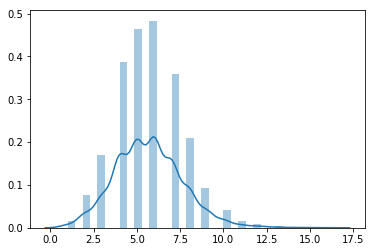

In [131]:
tree_heights = list(chain(*[[dtree[0].tree().height() for dtree in art_sentences] for art_sentences in news_df['parse_trees']]))

statistics.mean(tree_heights)
statistics.median(tree_heights)
seaborn.distplot(tree_heights)

We see that the average tree height is 5.6 and the median tree height is 6.0. We see the distribution of height levels among the sentences in our sampled news items. Some news items have complexity especially when doing quotes but other than that, the sentences tend to not be as complex as I would expect them to be in, for example, narrative literature.

Things I can extract for subsequent analysis: Verbs acted by someone specific, like Trump, the adjective phrases used to describe climate change, 

In [179]:
news_df['parse_sents'] = news_df['sentences'].apply(lambda sentlist: [list(parsed) for parsed in stanford.parser.parse_sents(sentlist)])

ValueError: Tree.read(): expected ')' but got 'end-of-string'
            at index 172.
                "...   (. .)))"
                              ^

In [209]:
#list(list(stanford.parser.parse_sents(news_df['sentences'].iloc[32]))[0])
without_problematic_one = news_df[~(news_df['author'] == 'Staff Writer')]
news_df2 = without_problematic_one
news_df2['parse_sents'] = news_df2['sentences'].apply(lambda sentlist: [list(parsed) for parsed in stanford.parser.parse_sents(sentlist)])


ValueError: Tree.read(): expected ')' but got 'end-of-string'
            at index 172.
                "...   (. .)))"
                              ^

There seems to be a problem with some of my news items having an open parenthesis that doesn't close. I didn't know the parser were that sensitive to this.

In [232]:
news_df2=news_df2.iloc[0:15]
print(news_df2.text.iloc[14])

California’s hard-charging green governor is shaking things up once again on the world stage. In an affront to President Donald Trump’s controversial decision to pull the United States out of the Paris climate-change agreement, Gov. Jerry Brown will announce a major initiative, inviting nations around the world to join California at a global “climate action” summit meeting in San Francisco.  The video message — to be aired before tens of thousands gathered at the Global Citizen Festival in Hamburg, Germany — comes right in the middle of Trump’s closely watched appearance at the G20 summit.  “It’s up to you and it’s up to me and tens of millions of other people to get it together to roll back the forces of carbonization and join together to combat the existential threat of climate change,” Brown said in prepared remarks releasedby his office. “That is why we’re having the Climate Action Summit in San Francisco, September 2018. President Trump is trying to get out of the Paris Agreement,

Okay. After significantly decreasing the sample to 14 articles, I've read them all and they don't have any unclosed parenthesis. I'm not sure why the parser is just not working with them. 
I'll include code that I think would have done one of the analysis but I can't run this at all on my corpus.

In [ ]:
#Parsing
news_df2['parse_sents'] = news_df2['sentences'].apply(lambda sentlist: [list(parsed) for parsed in stanford.parser.parse_sents(sentlist)])

# Getting verbs from China
chinaVerbs = news_df['parse_trees'].apply(lambda treelist: [treeSubRelation(each_tree, 'VBN', 'NNP', 'China') for each_tree in treelist])

# Getting climate change verbs
cchangeverbs = news_df['parse_trees'].apply(lambda treelist: [treeSubRelation(each_tree, 'VBN', 'NN', 'climate', 'change') for each_tree in treelist])

# Getting adjectives on 'action'
actionadjs = cchangeverbs = news_df['parse_trees'].apply(lambda treelist: [treeSubRelation(each_tree, 'JJ', 'NN', 'action') for each_tree in treelist])

# Getting adjectives on 'agreement'
actionadjs = cchangeverbs = news_df['parse_trees'].apply(lambda treelist: [treeSubRelation(each_tree, 'JJ', 'NN', 'agreement') for each_tree in treelist])

# Getting noun phrases by 'Trump'
actionadjs = cchangeverbs = news_df['parse_trees'].apply(lambda treelist: [treeRelation(each_tree, 'NP', 'Trump') for each_tree in treelist])

😞😢

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [134]:
ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.2 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 18.071 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [19.8 sec].
[main] INFO edu.stanford.nlp.pip

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [135]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

The above parsing only leaves 5 items about Trayvon Martin. One of them is false, as he was not African. However, if we had a large corpus of similar news items, we could compute the number of times 'African American' is coupled with the verb 'was', compared to other groups and their verb tenses, to figure out if certain groups are being described as deceased or to uncover bias in active verbs.
An example of that code would be:

In [172]:
ieDF[ieDF['object'].apply(lambda x: 'African American' in x)]['verb'].value_counts()

was    1
Name: verb, dtype: int64

These approaches are useful in terms of determining actors and objects. Grabbing inspiration from the orienting read of this week, I could look at what specific actors (countries, for example) are 'doing' in the articles of climate change and then attempt to find patterns.

And we can also look for subject, object, target triples in one of the reddit stories.

In [ ]:
ieDF = stanford.openIE(redditTopScores['text'][0])

In [ ]:
ieDF

That's almost 200 triples in only:

In [ ]:
len(redditTopScores['sentences'][0])

sentences and

In [ ]:
sum([len(s) for s in redditTopScores['sentences'][0]])

words.

Lets find at the most common subject in this story.

In [ ]:
ieDF['subject'].value_counts()

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [ ]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

and the following objects

In [ ]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [ ]:
stanford.startCoreServer()

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.